<a href="https://colab.research.google.com/github/kkharon/iS/blob/main/Task_9_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scipy

In [ ]:
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15079 sha256=675f321305f7cd96530984ccb18c6280bbc1bc5edd3b07de5ff848aaa3d3cc92
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [ ]:
!pip install sklearn-genetic-opt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy import optimize as opt
from geneticalgorithm import geneticalgorithm as ga
from sympy import diff

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold

In [ ]:
time_list = []

In [ ]:
# Функция Стыбинского-Танга
# Напишем фукцию при n = 2 (будут использоваться x1 и x2)

def styblinski_tang(x):
  x1, x2 = x
  return 0.5 * ((x1**4 + x2**4) - 16 * (x1**2 + x2**2)+ 5 * (x1 + x2))

def styblinski_tang_wrapper(x1, x2):
  return styblinski_tang([x1, x2])

Визуализация

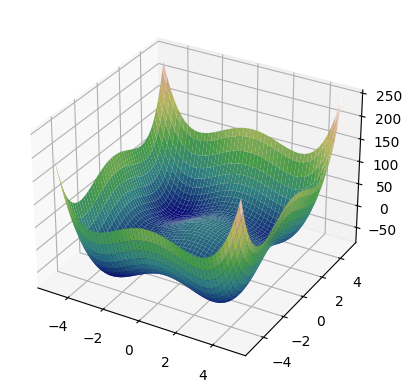

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

Z = np.array([styblinski_tang_wrapper(xi, yi) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

surface = ax.plot_surface(X, Y, Z, cmap='gist_earth')
plt.show()

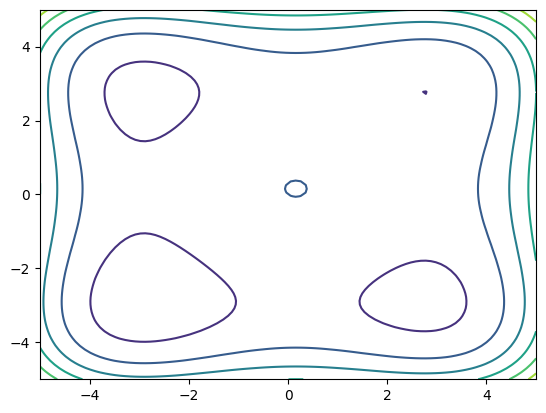

In [ ]:
plt.contour(X,Y,Z)
plt.show()

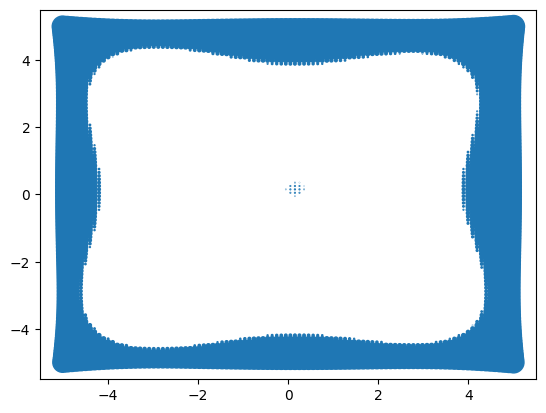

In [ ]:
plt.scatter(X, Y, Z)
plt.show()

## Классический алгоритм оптимизации (Ньютона)

Начнем из точки (-1, -1) и проделаем 100 итераций

In [ ]:
# Параметры для алгоритма Ньютона
initial_guess = [-1, -1]

newton_results = []

def jac_styblinski_tang(x):
  grad = 4 * x**3 - 32 * x + 5
  return grad

start_time = time.time()

for _ in range(100):
  res = opt.minimize(styblinski_tang, initial_guess, method='Newton-CG', jac=jac_styblinski_tang)
  newton_results.append(res.fun)

end_time = time.time()

time_list.append(end_time - start_time)

## Эволюционный алгоритм оптимизации

In [ ]:
# параметры
population_size = 50
max_generations = 100
mutation_rate = 0.2
crossover_rate = 0.8

In [ ]:
def evolutionary_optimization():
  # 1. Инициализация
  population = np.random.uniform(-5, 5, (population_size, 2))

  # Лучшие значения для каждого поколения
  best_values_per_generation = []

  for generation in range(max_generations):
    # 2. Оценка
    fitness_values = [-styblinski_tang(ind) for ind in population]

    # Коррекция фитнеса
    offset = min(fitness_values)
    fitness_values = [fv - offset for fv in fitness_values]

    # Нормализация вероятностей
    p = fitness_values / np.sum(fitness_values)

    # Сохрание лучшего значения для текущего поколения
    best_individual = population[np.argmax(fitness_values)]
    best_values_per_generation.append(-styblinski_tang(best_individual))

    # 3. Селекция
    selected = np.random.choice(population_size, size=population_size, p=p)

    # 4. Скрещивание
    children = []
    for i in range(0, population_size, 2):
      parent1, parent2 = population[selected[i]], population[selected[i+1]]
      child1, child2 = parent1.copy(), parent2.copy()
      if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(2)
        child1[:crossover_point], child2[:crossover_point] = parent2[:crossover_point], parent1[:crossover_point]
      children.extend((child1, child2))

    # 5. Мутация
    for child in children:
      if np.random.rand() < mutation_rate:
        mutation_point = np.random.randint(2)
        child[mutation_point] += np.random.uniform(-1, 1)

    # 6. Замена
    population = np.array(children)

  return best_individual, best_values_per_generation

In [ ]:
evolutionary_final_results = []
all_generational_best_values = []

start_time = time.time()

for _ in range(100):
  best, best_values_per_generation = evolutionary_optimization()
  evolutionary_final_results.append(styblinski_tang(best))
  all_generational_best_values.append(best_values_per_generation)

end_time = time.time()

time_list.append(end_time - start_time)

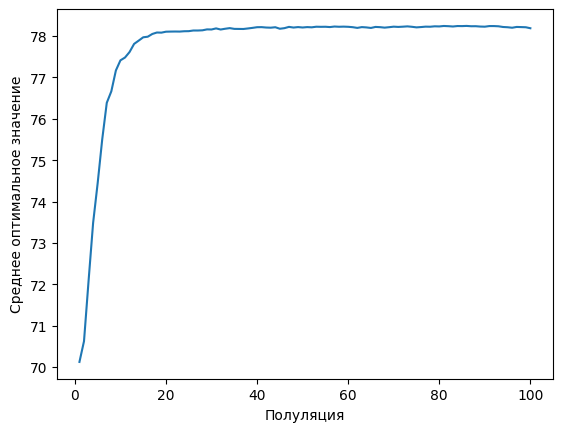

In [ ]:
# Визуализация результатов
populations = list(range(1, max_generations + 1))
avg_best_values = np.mean(all_generational_best_values, axis=0)
plt.plot(populations, avg_best_values)
plt.xlabel('Полуляция')
plt.ylabel('Среднее оптимальное значение')
plt.show()

## Анализ результатов

In [ ]:
newton_results = [x for x in newton_results if np.isfinite(x)]
evolutionary_results = [x for x in evolutionary_final_results if np.isfinite(x)]

newton_mean = np.mean(newton_results)
newton_variance = np.var(newton_results)
evolutionary_mean = np.mean(evolutionary_results)
evolutionary_variance = np.var(evolutionary_results)

pd.DataFrame({'Алгоритм': ['Ньютона', 'Эволюционный'],
              'Mean': [newton_mean, evolutionary_mean],
              'Variance': [newton_variance, evolutionary_variance],
              'Time': time_list})

,Алгоритм,Mean,Variance,Time
0,Ньютона,-78.332331,0.000000,0.098036
1,Эволюционный,-78.189526,0.018716,6.516525


Применим эволюционный алгоритм оптимизации по подбору оптимальных параметров у моделей SVM, RF и KNN на примере задачи об ирисах.

# SVM

Загрузка модели iris

In [ ]:
iris = load_iris()

#данные для входной части модели
iris_data = iris.data
# данные для выходной части модели
iris_target = iris.target

In [ ]:
n_samples = len(iris_data)
X = iris_data
y = iris_target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

документация по используемым параметрам

https://sklearn-genetic-opt.readthedocs.io/en/latest/api/gasearchcv.html

In [ ]:
parameters = {'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),
              'C': Integer(1, 10)}
model = SVC()

cv = StratifiedKFold(n_splits=3, shuffle=True)

# criteria='max', так как задача максимизировать точность (accuracy)
evolved_estimator = GASearchCV(estimator=model,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=parameters,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [ ]:
evolved_estimator.fit(X_train,y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.7825 	0.272551   	0.991667   	0.366667   
1  	17    	0.96   	0.0104083  	0.983333   	0.941667   
2  	18    	0.9675 	0.00946485 	0.983333   	0.958333   
3  	19    	0.971667	0.00763763 	0.983333   	0.966667   
4  	18    	0.975   	0.0111803  	0.983333   	0.95       
5  	19    	0.975   	0.00833333 	0.983333   	0.966667   
6  	17    	0.9775  	0.00916667 	0.983333   	0.958333   
7  	17    	0.980833	0.00533594 	0.983333   	0.966667   
8  	17    	0.980833	0.00533594 	0.983333   	0.966667   
9  	19    	0.983333	2.22045e-16	0.983333   	0.983333   
10 	18    	0.976667	0.00816497 	0.983333   	0.966667   
11 	17    	0.973333	0.00897527 	0.983333   	0.958333   
12 	18    	0.979167	0.00671855 	0.983333   	0.966667   
13 	19    	0.980833	0.00533594 	0.983333   	0.966667   
14 	17    	0.98    	0.00666667 	0.983333   	0.966667   
15 	17    	0.978333	0.01       	0.983333   	0.958333   
16 	19    	0.981667	0.005      	0.983333   	0.966667

1.0

In [ ]:
evolved_estimator.best_params_

{'kernel': 'rbf', 'C': 6}

**Оптимальные параметры: 'kernel': 'rbf', 'C': 6**

/usr/local/lib/python3.10/dist-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


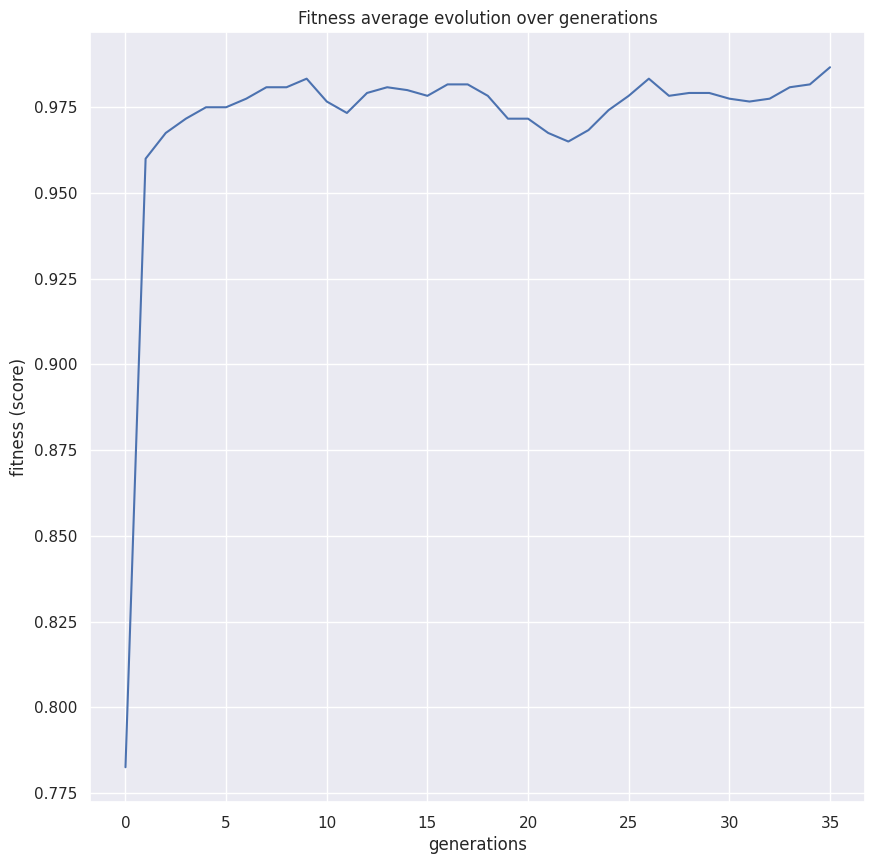

In [ ]:
plot_fitness_evolution(evolved_estimator)
plt.show()

# RandomForest

In [ ]:
param_grid = {'max_depth': Integer(2, 25),
              'n_estimators': Integer(100, 300)}

rf = RandomForestClassifier()

evolved_estimator = GASearchCV(estimator=rf,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [ ]:
evolved_estimator.fit(X_train, y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.9425 	0.00692219 	0.95       	0.933333   
1  	18    	0.95   	0.00645497 	0.958333   	0.941667   
2  	18    	0.954167	0.00559017 	0.958333   	0.941667   
3  	19    	0.951667	0.00726483 	0.958333   	0.941667   
4  	18    	0.946667	0.00666667 	0.958333   	0.941667   
5  	15    	0.945833	0.00559017 	0.958333   	0.941667   
6  	18    	0.950833	0.00448764 	0.958333   	0.941667   
7  	17    	0.9525  	0.00381881 	0.958333   	0.95       
8  	19    	0.95    	0.0111803  	0.958333   	0.925      
9  	18    	0.951667	0.0062361  	0.958333   	0.941667   
10 	19    	0.9525  	0.00650854 	0.958333   	0.941667   
11 	16    	0.955   	0.00408248 	0.958333   	0.95       
12 	14    	0.956667	0.00333333 	0.958333   	0.95       
13 	17    	0.9575  	0.0025     	0.958333   	0.95       
14 	18    	0.958333	0          	0.958333   	0.958333   
15 	20    	0.956667	0.005      	0.958333   	0.941667   
16 	17    	0.955   	0.00666667 	0.958333   	0.94166

1.0

In [ ]:
evolved_estimator.best_params_

{'max_depth': 19, 'n_estimators': 175}

**Оптимальные параметры: 'max_depth': 19, 'n_estimators': 175**

/usr/local/lib/python3.10/dist-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


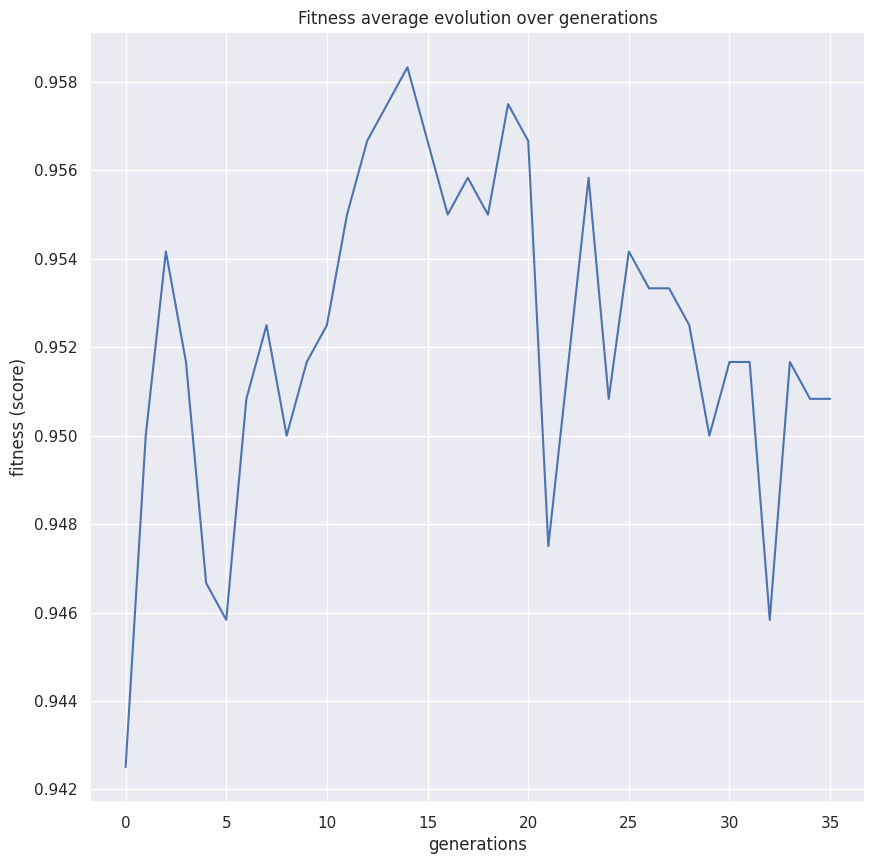

In [ ]:
plot_fitness_evolution(evolved_estimator)
plt.show()

# KNN

In [ ]:
parameters = {'n_neighbors': Integer(3,10),
              'leaf_size': Integer(3,50)}

knn = KNeighborsClassifier()

evolved_estimator = GASearchCV(estimator=knn,
                               cv=cv,
                               scoring='accuracy',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=parameters,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [ ]:
evolved_estimator.fit(X_train,y_train)
y_predicy_ga = evolved_estimator.predict(X_test)
accuracy_score(y_test,y_predicy_ga)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	fitness	fitness_std	fitness_max	fitness_min
0  	10    	0.9475 	0.0190212  	0.975      	0.916667   
1  	17    	0.9675 	0.00692219 	0.975      	0.958333   
2  	17    	0.970833	0.00559017 	0.975      	0.958333   
3  	17    	0.9675  	0.00692219 	0.975      	0.958333   
4  	17    	0.965   	0.00816497 	0.975      	0.95       
5  	17    	0.971667	0.00408248 	0.975      	0.966667   
6  	19    	0.97    	0.00408248 	0.975      	0.966667   
7  	19    	0.968333	0.005      	0.975      	0.958333   
8  	19    	0.968333	0.0062361  	0.975      	0.958333   
9  	20    	0.97    	0.01       	0.975      	0.941667   
10 	18    	0.970833	0.00416667 	0.975      	0.966667   
11 	20    	0.97    	0.00552771 	0.975      	0.958333   
12 	19    	0.968333	0.0062361  	0.975      	0.958333   
13 	19    	0.966667	0.00527046 	0.975      	0.958333   
14 	19    	0.971667	0.00408248 	0.975      	0.966667   
15 	19    	0.971667	0.00763763 	0.975      	0.95       
16 	17    	0.973333	0.00333333 	0.975      	0.96666

1.0

In [ ]:
evolved_estimator.best_params_

{'n_neighbors': 8, 'leaf_size': 17}

**Оптимальные параметры: 'n_neighbors': 8, 'leaf_size': 17**


/usr/local/lib/python3.10/dist-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


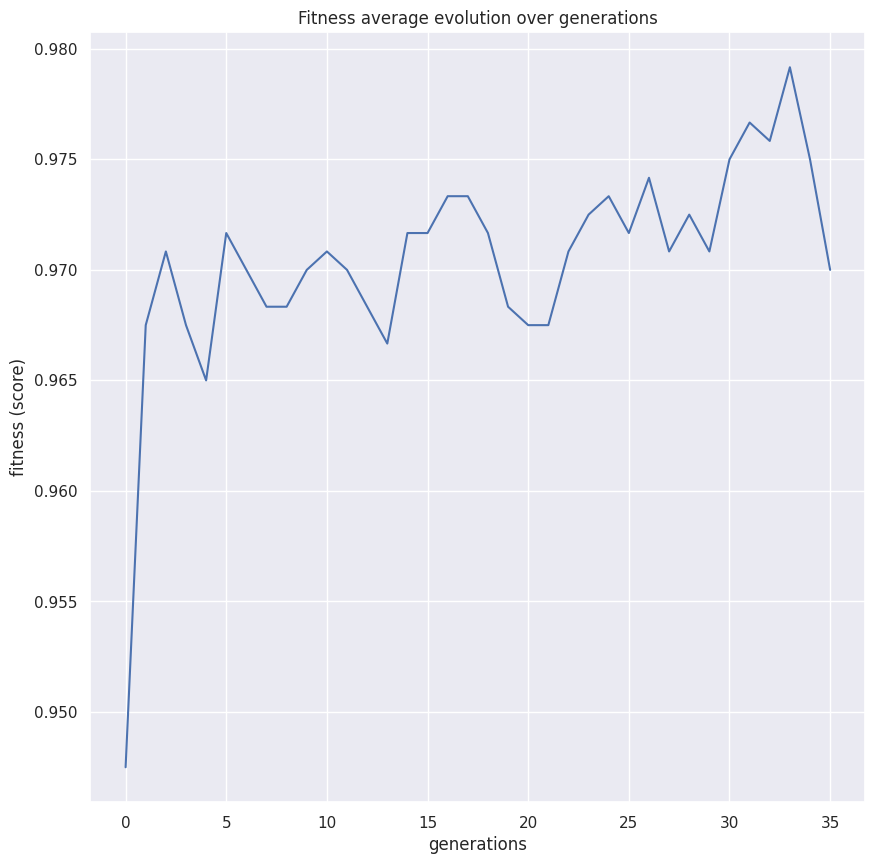

In [ ]:
plot_fitness_evolution(evolved_estimator)
plt.show()